[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1I30RErpvVhGLU7Ae7KB7p02v-heB0WMC#scrollTo=degBx0GMG8HF)

## setting up dataset

In [ ]:
import kagglehub

# Download latest version
download_path = kagglehub.dataset_download(
    "birdy654/cifake-real-and-ai-generated-synthetic-images",
)

image_path = "/content/kaggle_datasets"

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.


In [ ]:
import torch as torch
from torch import nn
import numpy as np

In [ ]:
import os

print("Path to downloaded files:", download_path)

Path to downloaded files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [ ]:
!ln -s {download_path} {image_path}

In [ ]:
image_train_real_path = image_path + "/train/REAL"
print("Number of files in "+ image_train_real_path + ": " + str(len([name for name in os.listdir(image_train_real_path)])))
print("Path to dataset files: " + image_path )

Number of files in /content/kaggle_datasets/train/REAL: 50000
Path to dataset files: /content/kaggle_datasets


In [ ]:
from pathlib import Path
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Subset

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.ImageFolder(
    Path(image_path + "/train"),
    transform=transform)

print("loaded traindata")

test_dataset = datasets.ImageFolder(
    Path(image_path +"/test"),
    transform=transform)

print("loaded testdata")

len(train_dataset), len(test_dataset)


loaded traindata
loaded testdata


(100000, 20000)

In [ ]:
image, label = train_dataset[1]
image.shape, label, type(label)

(torch.Size([3, 32, 32]), 0, int)

In [ ]:
i, label = train_dataset[-1]
print(label)

1


In [ ]:
def setManualSeed():
  torch.manual_seed(64)

In [ ]:
from torch.utils.data import DataLoader
setManualSeed()

batch_size = 64

train_dataloader = DataLoader(
  dataset=train_dataset,
  batch_size=batch_size,
  shuffle=True)

test_dataloader = DataLoader(
  dataset=test_dataset,
  batch_size=batch_size,
  shuffle=False)


print(f"number of train batches: {len(train_dataloader)}")
print(f"number of test batches: {len(test_dataloader)}")


number of train batches: 1563
number of test batches: 313


In [ ]:
classnames = train_dataloader.dataset.classes
classindex = train_dataloader.dataset.class_to_idx
classnames, classindex

(['FAKE', 'REAL'], {'FAKE': 0, 'REAL': 1})

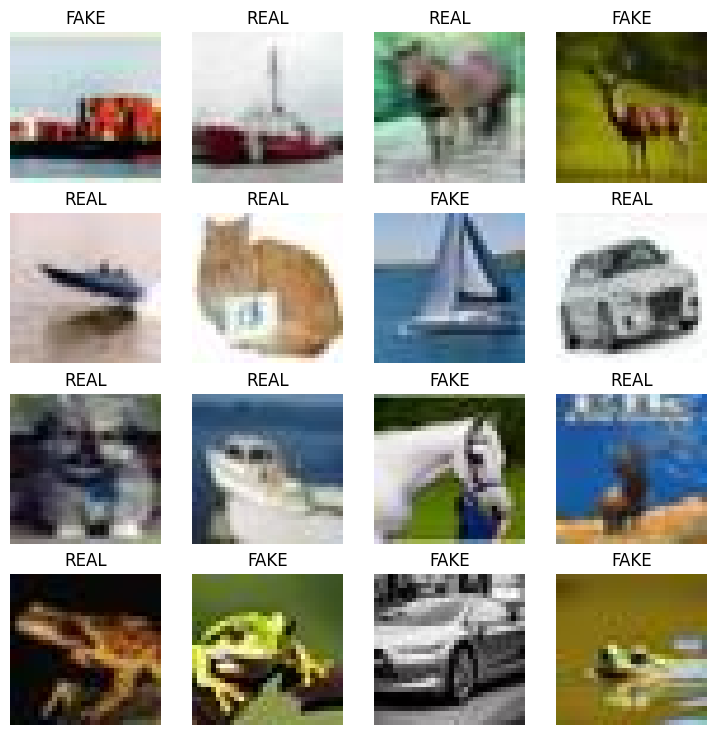

In [ ]:
# visualising the data
torch.manual_seed(64)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,9))
rows, cols = 4,4

for i in range(1, rows*cols +1):

  rand_int = torch.randint(0,len(train_dataset), size=[1]).item()
  temp_data = train_dataset[rand_int]

  temp_image, temp_label = temp_data

  # conver to h,w,c
  img = temp_image.permute(1, 2, 0)

  img = img.numpy()
  fig.add_subplot(rows,cols,i)
  plt.imshow(img)
  plt.title(classnames[temp_label])
  plt.axis(False)

plt.show()



## Building the first model

In [ ]:
# device agnostic code
setManualSeed()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# evaluation function -> used to evaluate model accuracy
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
# create the accuracy function
from torcheval.metrics import BinaryAccuracy

accMetric = BinaryAccuracy()

def getAccMetric(input, target):
  accMetric.update(input, target)
  return accMetric.compute()

def resetAccMetric():
  accMetric.reset()

# test the function
getAccMetric(torch.tensor([1,0,1,0]), torch.tensor([1,1,1,0]))

tensor(0.7500)

In [ ]:
# create a timer to measure how long it takes for the model to run
from timeit import default_timer as timer

def printTimeElapsed(
    start: int,
    end: int) -> int:
  totalTimeElapsed = end - start
  print(f"Time elapsed: {totalTimeElapsed:.4f} seconds")


In [ ]:
# create a training loop
setManualSeed()

def run_train_loop(
    model: torch.nn.Module,
    loss_function: torch.nn.Module,
    optimiser: torch.optim.Optimizer,
    dataLoader: torch.utils.data.dataloader,
    acc_function,
    device: torch.device,
    batch_limit: int = 0):

  if batch_limit == 0:
    batch_limit = len(dataLoader)

  batch_quater = batch_limit//4
  batch_display = batch_quater

  train_acc = 0
  train_loss = 0

  model.to(device)
  model.train()

  for batch, (x, y) in enumerate(dataLoader):
    x, y = x.to(device), y.to(device)

    y_preds = model(x)

    loss = loss_function(y_preds.squeeze(dim=1).float(), y.float())
    train_loss += loss
    pred_probs = torch.sigmoid(y_preds.squeeze(dim=1)).round()
    train_acc += acc_function(pred_probs, y)

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    if (batch == batch_display):
      print(f"Looked at batches: {batch}/{len(dataLoader)}")
      batch_display+= batch_quater

    if (batch >= batch_limit):
      break


  train_loss = train_loss / len(dataLoader)
  train_acc = train_acc / len(dataLoader)

  print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")




In [ ]:
# testing loop
setManualSeed()

def run_test_loop(
    model: torch.nn.Module,
    loss_function: torch.nn.Module,
    dataLoader: torch.utils.data.dataloader,
    acc_function,
    device: torch.device,
    do_test: bool = True):

  if do_test == False:
    return

  test_loss = 0
  test_acc = 0

  model.to(device)
  model.eval()

  with torch.inference_mode():
    for x,y in dataLoader:

      x, y = x.to(device), y.to(device)

      y_preds = model(x)

      test_loss += loss_function(y_preds.squeeze(dim=1).float(), y.float())
      pred_probs = torch.sigmoid(y_preds).squeeze(dim=1).round()
      test_acc += acc_function(pred_probs, y)

    test_loss /= len(dataLoader)
    test_acc /= len(dataLoader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  return test_acc, test_loss


In [ ]:
# The model
setManualSeed()

class AIdentifierV0(nn.Module):

  def __init__(self, input_units: int, output_units: int, hidden_units: int, hidden_linear_units: int):
    super().__init__()

    self.conv_stage_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_units,
        out_channels=hidden_units,
        kernel_size=(7,7),
        stride=1,
        padding=3
      ),
      nn.ReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(7,7),
        stride=1,
        padding=3
      ),
      nn.ReLU(),

      nn.MaxPool2d(
          kernel_size=(2,2),
          stride=2
      )
    )

    self.conv_stage_2 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.ReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.ReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.ReLU(),

      nn.MaxPool2d(
          kernel_size=(2,2),
          stride=2
      )
    )

    self.conv_stage_3 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.ReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.ReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.ReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.ReLU(),

      nn.MaxPool2d(
          kernel_size=(3,3),
          stride=1
      )
    )

    self.LinearLayer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*6*6,
            out_features=hidden_linear_units,
        ),
        nn.Linear(
            in_features=hidden_linear_units,
            out_features=output_units,
        )
    )

  def forward(self, x):
    x = self.conv_stage_1(x)
    # print(x.shape)
    x = self.conv_stage_2(x)
    # print(x.shape)
    x = self.conv_stage_3(x)
    # print(x.shape)
    x = self.LinearLayer(x)
    # print(x.shape)
    return x


In [ ]:
setManualSeed()

modelV0 = AIdentifierV0(
    input_units=3,
    output_units=1,
    hidden_units=16,
    hidden_linear_units=64
).to(device)

next(modelV0.parameters())

Parameter containing:
tensor([[[[-0.0744,  0.0163, -0.0533,  ..., -0.0047,  0.0558, -0.0554],
          [-0.0511,  0.0820,  0.0085,  ..., -0.0619, -0.0471,  0.0277],
          [-0.0026, -0.0258,  0.0623,  ..., -0.0111,  0.0488, -0.0825],
          ...,
          [-0.0008,  0.0156, -0.0102,  ...,  0.0461, -0.0243, -0.0039],
          [-0.0180, -0.0071,  0.0432,  ...,  0.0722,  0.0152, -0.0487],
          [-0.0002, -0.0728, -0.0608,  ..., -0.0069, -0.0225, -0.0149]],

         [[ 0.0777,  0.0232, -0.0300,  ..., -0.0406, -0.0057,  0.0717],
          [ 0.0771,  0.0098, -0.0682,  ...,  0.0426,  0.0216, -0.0766],
          [-0.0719, -0.0031,  0.0211,  ...,  0.0714, -0.0478, -0.0642],
          ...,
          [-0.0380,  0.0645, -0.0622,  ...,  0.0779, -0.0420,  0.0541],
          [ 0.0100,  0.0381,  0.0726,  ...,  0.0036,  0.0777,  0.0394],
          [-0.0505, -0.0382,  0.0744,  ...,  0.0700, -0.0555, -0.0015]],

         [[ 0.0014, -0.0282, -0.0399,  ..., -0.0627,  0.0252,  0.0166],
        

In [ ]:
image.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [ ]:
# pass data through to test

modelV0(image.unsqueeze(0).to(device))

tensor([[0.1173]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# create loss function and optmiser

loss_fn = nn.BCEWithLogitsLoss()

modelV0_optimiser = torch.optim.SGD(
    params=modelV0.parameters(),
    lr = 0.02,
    momentum = 0.8
)



In [ ]:
# train the model

from tqdm.auto import tqdm

start_train_time = timer()

total_epochs = 6
count_epochs = 0
epoch_list = []
total_test_loss = []
total_test_acc = []


for epoch in tqdm(range(total_epochs)):

  print(f"Epoch: {epoch+1}")
  resetAccMetric()

  run_train_loop(
      model=modelV0,
      loss_function=loss_fn,
      optimiser=modelV0_optimiser,
      dataLoader=train_dataloader,
      acc_function=getAccMetric,
      device=device
  )

  resetAccMetric()

  test_results = run_test_loop(
        model=modelV0,
        loss_function=loss_fn,
        dataLoader=test_dataloader,
        acc_function=getAccMetric,
        device=device
      )

  count_epochs += 1

  total_test_acc.append(round(test_results[0].item(), 2))
  total_test_loss.append(round(test_results[1].item(), 2))
  epoch_list.append(count_epochs)



end_train_time = timer()
printTimeElapsed(
    start=start_train_time,
    end=end_train_time
)


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1
Looked at batches: 390/1563
Looked at batches: 780/1563
Looked at batches: 1170/1563
Looked at batches: 1560/1563
Train loss: 0.6933 | Train acc: 0.4959
Test loss: 0.6934 | Test acc: 0.8452
Epoch: 2
Looked at batches: 390/1563
Looked at batches: 780/1563
Looked at batches: 1170/1563
Looked at batches: 1560/1563
Train loss: 0.6933 | Train acc: 0.4998
Test loss: 0.6932 | Test acc: 0.1548
Epoch: 3
Looked at batches: 390/1563
Looked at batches: 780/1563
Looked at batches: 1170/1563
Looked at batches: 1560/1563
Train loss: 0.6933 | Train acc: 0.5032
Test loss: 0.6931 | Test acc: 0.1548
Epoch: 4
Looked at batches: 390/1563
Looked at batches: 780/1563
Looked at batches: 1170/1563
Looked at batches: 1560/1563
Train loss: 0.6874 | Train acc: 0.5081
Test loss: 0.6538 | Test acc: 0.4119
Epoch: 5
Looked at batches: 390/1563
Looked at batches: 780/1563
Looked at batches: 1170/1563
Looked at batches: 1560/1563
Train loss: 0.5870 | Train acc: 0.6416
Test loss: 0.5124 | Test acc: 0.7815
Epoch

In [ ]:
print(epoch_list)
print(total_test_acc)


[1, 2, 3, 4, 5, 6]
[0.85, 0.15, 0.15, 0.41, 0.78, 0.84]


In [ ]:
import matplotlib.pyplot as plt

def drawAccGraph(epoch_list, total_test_acc, total_test_loss):
  fig = plt.figure(figsize=(6,7))

  plt.plot( epoch_list, total_test_acc, "b", label="test accuracy" )
  plt.plot( epoch_list, total_test_loss, "r", label="test loss" )

  plt.xticks(epoch_list)

  plt.gca().set_xlabel("epoch")
  plt.ylabel("percent %")
  plt.legend( loc="upper left" )


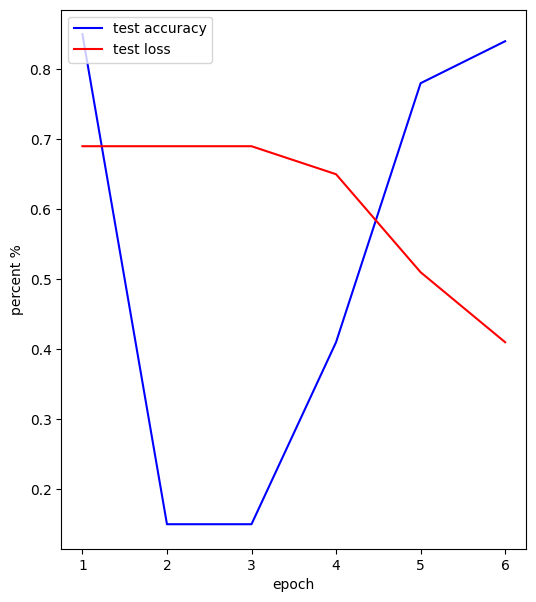

In [ ]:
drawAccGraph(epoch_list, total_test_acc, total_test_loss)

## get custom data to test model accuracy

In [ ]:
from PIL import Image
import requests

test_image_url = 'https://cdn.pixabay.com/photo/2024/01/24/15/10/ai-generated-8529788_1280.jpg'
path = ''
if path != '':
  image = Image.open(path).convert("RGB")
elif test_image_url != '':
  image = Image.open(requests.get(test_image_url, stream=True).raw).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
 ])

image_tensor = transform(image)

image_tensor.shape

torch.Size([3, 32, 32])

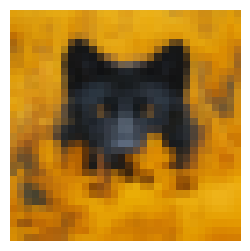

In [ ]:
fig = plt.figure(figsize=(3,3))

img = image_tensor.permute(1, 2, 0)

img = img.numpy()
plt.imshow(img)
plt.axis(False)

plt.show()

In [ ]:
def model_testImagePass(model: torch.nn.modules, image_url: str):

  image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

  transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
  ])

  image_tensor = transform(image)

  model.eval()
  with torch.inference_mode():
    model_output = model(image_tensor.unsqueeze(0).to(device))
    prediction = torch.sigmoid(model_output.squeeze(dim=1)).item()

  prediction_label = classnames[int(round(prediction))]

  print(f"The inputted image is: {prediction_label} | probability of being real: {prediction:.2f}" )

  fig = plt.figure(figsize=(3,3))


  plt.imshow(image)
  plt.axis(False)
  plt.title(prediction_label)

  plt.show()

The inputted image is: FAKE | probability of being real: 0.05


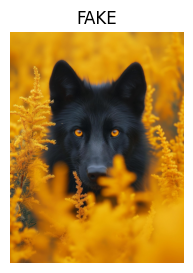

In [ ]:
model_testImagePass(modelV0, test_image_url)

## model takes too long to train -> try using batch normalisation

## also try smaller kernels for more specific detail learning

In [ ]:
# The second model
setManualSeed()

class AIdentifierV1(nn.Module):

  def __init__(self, input_units: int, output_units: int, hidden_units: int, hidden_linear_units: int):
    super().__init__()

    self.conv_stage_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_units,
        out_channels=hidden_units,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units*2,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units*2),
      nn.LeakyReLU(),

      nn.MaxPool2d(
          kernel_size=(2,2),
          stride=2
      )
    )

    self.conv_stage_2 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units*2,
        out_channels=hidden_units*2,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units*2),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*2,
        out_channels=hidden_units*2,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units*2),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*2,
        out_channels=hidden_units*4,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units*4),
      nn.LeakyReLU(),

      nn.MaxPool2d(
          kernel_size=(2,2),
          stride=2
      )
    )

    self.conv_stage_3 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units*4,
        out_channels=hidden_units*4,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units*4),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*4,
        out_channels=hidden_units*4,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units*4),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*4,
        out_channels=hidden_units*4,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units*4),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*4,
        out_channels=hidden_units*8,
        kernel_size=(3,3),
        stride=1,
        padding=1
      ),
      nn.BatchNorm2d(hidden_units*8),
      nn.LeakyReLU(),

      nn.MaxPool2d(
          kernel_size=(3,3),
          stride=1
      )
    )

    self.LinearLayer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*6*6*8,
            out_features=hidden_linear_units*2,
        ),
        nn.Linear(
            in_features=hidden_linear_units*2,
            out_features=hidden_linear_units,
        ),
        nn.Linear(
            in_features=hidden_linear_units,
            out_features=hidden_linear_units//2,
        ),
        nn.Linear(
            in_features=hidden_linear_units//2,
            out_features=output_units,
        )
    )

  def forward(self, x):
    x = self.conv_stage_1(x)
    #print(x.shape)
    x = self.conv_stage_2(x)
    # print(x.shape)
    x = self.conv_stage_3(x)
    # print(x.shape)
    x = self.LinearLayer(x)
    #print(x.shape)
    return x

In [ ]:
setManualSeed()

modelV1 = AIdentifierV1(
    input_units=3,
    output_units=1,
    hidden_units=32,
    hidden_linear_units=64
)

modelV1(image_tensor.unsqueeze(0))

tensor([[0.2708]], grad_fn=<AddmmBackward0>)

In [ ]:
# setup optmiser and lossfn
loss_fn = nn.BCEWithLogitsLoss()

modelV1_optimiser = torch.optim.SGD(
    params=modelV1.parameters(),
    lr = 0.01,
    momentum = 0.9,
)


count_epochs = 0
epoch_list = []
total_test_loss = []
total_test_acc = []

In [ ]:
# training
setManualSeed()

from tqdm.auto import tqdm

start_train_time = timer()

total_epochs = 3

t_model = modelV1.to(device)

for epoch in tqdm(range(total_epochs)):
  epoch += 1

  print(f"Epoch: {epoch}")
  resetAccMetric()

  run_train_loop(
      model=t_model,
      loss_function=loss_fn,
      optimiser=modelV1_optimiser,
      dataLoader=train_dataloader,
      acc_function=getAccMetric,
      device=device,
  )

  resetAccMetric()

  test_results = run_test_loop(
        model=t_model,
        loss_function=loss_fn,
        dataLoader=test_dataloader,
        acc_function=getAccMetric,
        device=device,
      )


  total_test_acc.append(round(test_results[0].item(), 2))
  total_test_loss.append(round(test_results[1].item(), 2))

  if len(epoch_list) == 0:
    epoch_list.append(epoch)
  else:
    epoch_list.append(max(epoch_list) + epoch)



end_train_time = timer()
printTimeElapsed(
    start=start_train_time,
    end=end_train_time
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
Looked at batches: 390/1563
Looked at batches: 780/1563
Looked at batches: 1170/1563
Looked at batches: 1560/1563
Train loss: 0.2188 | Train acc: 0.8760
Test loss: 0.1911 | Test acc: 0.8945
Epoch: 2
Looked at batches: 390/1563
Looked at batches: 780/1563
Looked at batches: 1170/1563
Looked at batches: 1560/1563
Train loss: 0.1460 | Train acc: 0.9424
Test loss: 0.1342 | Test acc: 0.9558
Epoch: 3
Looked at batches: 390/1563
Looked at batches: 780/1563
Looked at batches: 1170/1563
Looked at batches: 1560/1563
Train loss: 0.1239 | Train acc: 0.9516
Test loss: 0.1295 | Test acc: 0.9476
Time elapsed: 330.9443 seconds


In [ ]:
print(epoch_list)
print(total_test_loss)

[1, 3, 6]
[0.19, 0.13, 0.13]


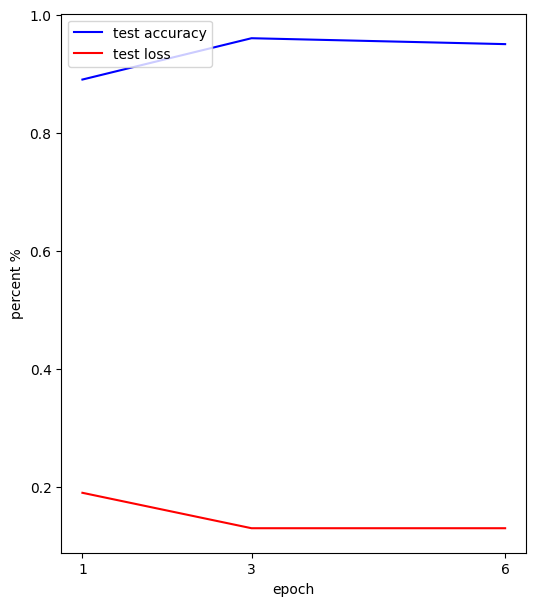

In [ ]:
drawAccGraph(epoch_list, total_test_acc, total_test_loss)

The inputted image is: REAL | probability of being real: 0.99


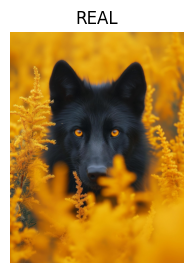

In [ ]:
model_testImagePass(modelV1, test_image_url)

## combine aspects of the two models

In [ ]:
setManualSeed()

class AIdentifierV2(nn.Module):

  def __init__(self, input_units: int, output_units: int, hidden_units: int, hidden_linear_units: int):
    super().__init__()

    self.conv_stage_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_units,
        out_channels=hidden_units,
        kernel_size=(7,7),
        stride=1,
        padding=3
      ),
      nn.BatchNorm2d(hidden_units),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units*2,
        kernel_size=(7,7),
        stride=1,
        padding=3
      ),
      nn.BatchNorm2d(hidden_units*2),
      nn.LeakyReLU(),

      nn.MaxPool2d(
          kernel_size=(2,2),
          stride=2
      )
    )

    self.conv_stage_2 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units*2,
        out_channels=hidden_units*2,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(hidden_units*2),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*2,
        out_channels=hidden_units*2,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(hidden_units*2),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*2,
        out_channels=hidden_units*2*2,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(hidden_units*2*2),
      nn.LeakyReLU(),

      nn.MaxPool2d(
          kernel_size=(2,2),
          stride=2
      )
    )

    self.conv_stage_3 = nn.Sequential(
      nn.Conv2d(
        in_channels=hidden_units*2*2,
        out_channels=hidden_units*2*2,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(hidden_units*2*2),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*2*2,
        out_channels=hidden_units*2*2,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(hidden_units*2*2),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*2*2,
        out_channels=hidden_units*2*2,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(hidden_units*2*2),
      nn.LeakyReLU(),

      nn.Conv2d(
        in_channels=hidden_units*2*2,
        out_channels=hidden_units*2*2*2,
        kernel_size=(5,5),
        stride=1,
        padding=2
      ),
      nn.BatchNorm2d(hidden_units*2*2*2),
      nn.LeakyReLU(),

      nn.MaxPool2d(
          kernel_size=(3,3),
          stride=1
      )
    )

    self.LinearLayer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*6*6*8,
            out_features=hidden_linear_units,
        ),
        nn.Linear(
            in_features=hidden_linear_units,
            out_features=hidden_linear_units*2
        ),
        nn.Linear(
            in_features=hidden_linear_units*2,
            out_features=output_units,
        )
    )

  def forward(self, x):
    x = self.conv_stage_1(x)
    # print(x.shape)
    x = self.conv_stage_2(x)
    # print(x.shape)
    x = self.conv_stage_3(x)
    # print(x.shape)
    x = self.LinearLayer(x)
    # print(x.shape)
    return x

In [ ]:
setManualSeed()

modelV2 = AIdentifierV2(
    input_units=3,
    output_units=1,
    hidden_units=16,
    hidden_linear_units=64
)

modelV2(image_tensor.unsqueeze(0))

tensor([[0.2239]], grad_fn=<AddmmBackward0>)

In [ ]:
setManualSeed()

batch_size = 256

train_dataloader = DataLoader(
  dataset=train_dataset,
  batch_size=batch_size,
  shuffle=True)

test_dataloader = DataLoader(
  dataset=test_dataset,
  batch_size=batch_size,
  shuffle=False)

print(f"number of train batches: {len(train_dataloader)}")
print(f"number of test batches: {len(test_dataloader)}")


number of train batches: 391
number of test batches: 79


In [ ]:
# loss fn and optimiser
loss_fn = nn.BCEWithLogitsLoss()

modelV2_optimiser = torch.optim.SGD(
    params = modelV2.parameters(),
    lr = 0.001,
    momentum=0.9
)

In [ ]:
V2_epoch_list = []
V2_test_loss = []
V2_test_acc = []

In [ ]:
# training
setManualSeed()

from tqdm.auto import tqdm

start_train_time = timer()

total_epochs = 3
t_model = modelV2.to(device)


for epoch in tqdm(range(total_epochs)):
  epoch += 1

  print(f"Epoch: {epoch}")
  resetAccMetric()

  run_train_loop(
      model=t_model,
      loss_function=loss_fn,
      optimiser=modelV2_optimiser,
      dataLoader=train_dataloader,
      acc_function=getAccMetric,
      device=device,
  )

  resetAccMetric()

  test_results = run_test_loop(
        model=t_model,
        loss_function=loss_fn,
        dataLoader=test_dataloader,
        acc_function=getAccMetric,
        device=device,
      )


  V2_test_acc.append(round(test_results[0].item(), 2))
  V2_test_loss.append(round(test_results[1].item(), 2))

  V2_epoch_list.append(epoch)



end_train_time = timer()
printTimeElapsed(
    start=start_train_time,
    end=end_train_time
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1
Looked at batches: 97/391
Looked at batches: 194/391
Looked at batches: 291/391
Looked at batches: 388/391
Train loss: 0.3073 | Train acc: 0.7868
Test loss: 0.2286 | Test acc: 0.9336
Epoch: 2
Looked at batches: 97/391
Looked at batches: 194/391
Looked at batches: 291/391
Looked at batches: 388/391
Train loss: 0.1849 | Train acc: 0.9254
Test loss: 0.1936 | Test acc: 0.9133
Epoch: 3
Looked at batches: 97/391
Looked at batches: 194/391
Looked at batches: 291/391
Looked at batches: 388/391
Train loss: 0.1544 | Train acc: 0.9374
Test loss: 0.1784 | Test acc: 0.9183
Time elapsed: 298.8497 seconds


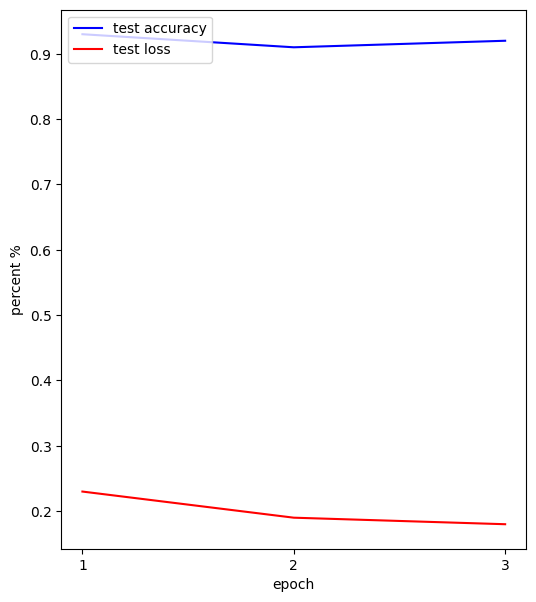

In [ ]:
drawAccGraph(
    epoch_list = V2_epoch_list,
    total_test_acc= V2_test_acc,
    total_test_loss= V2_test_loss
)

modelV2:
The inputted image is: FAKE | probability of being real: 0.45


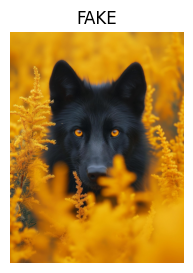


 modelV1:
The inputted image is: REAL | probability of being real: 0.99


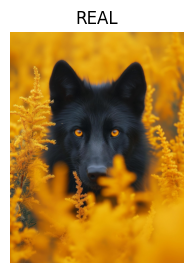


 modelV0:
The inputted image is: FAKE | probability of being real: 0.05


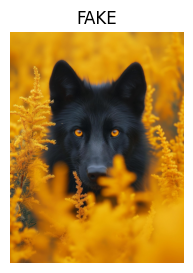

modelV2:
The inputted image is: FAKE | probability of being real: 0.20


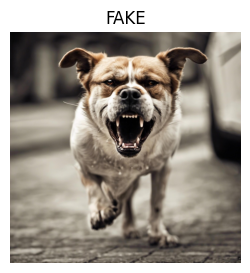


 modelV1:
The inputted image is: FAKE | probability of being real: 0.01


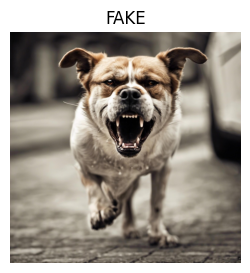


 modelV0:
The inputted image is: FAKE | probability of being real: 0.35


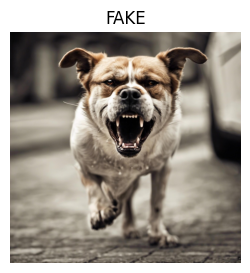

actual label: FAKE 

modelV2:
The inputted image is: REAL | probability of being real: 0.98


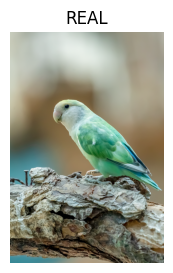


 modelV1:
The inputted image is: REAL | probability of being real: 0.73


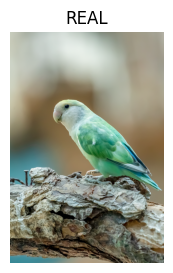


 modelV0:
The inputted image is: REAL | probability of being real: 0.92


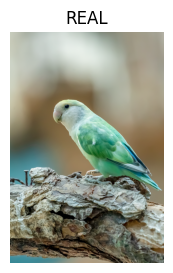

actual label: FAKE 

modelV2:
The inputted image is: FAKE | probability of being real: 0.13


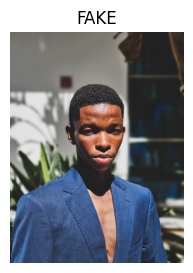


 modelV1:
The inputted image is: FAKE | probability of being real: 0.43


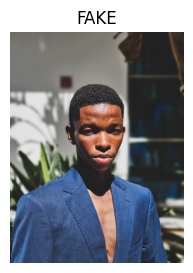


 modelV0:
The inputted image is: FAKE | probability of being real: 0.38


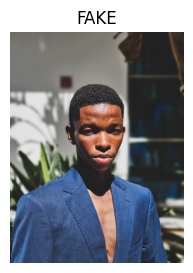

actual label: FAKE 

modelV2:
The inputted image is: REAL | probability of being real: 0.99


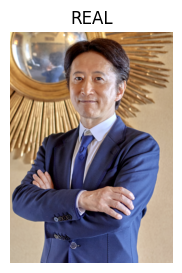


 modelV1:
The inputted image is: REAL | probability of being real: 1.00


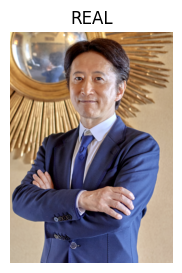


 modelV0:
The inputted image is: REAL | probability of being real: 0.85


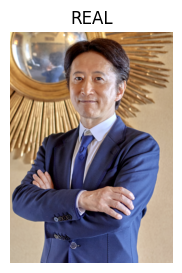

actual label: REAL 

modelV2:
The inputted image is: REAL | probability of being real: 0.94


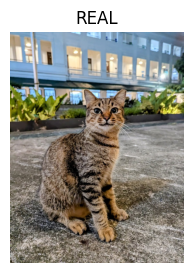


 modelV1:
The inputted image is: REAL | probability of being real: 0.99


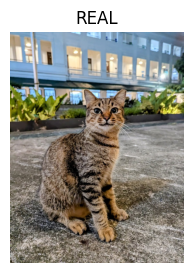


 modelV0:
The inputted image is: REAL | probability of being real: 0.79


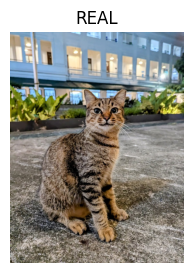

actual label: REAL 

modelV2:
The inputted image is: REAL | probability of being real: 0.96


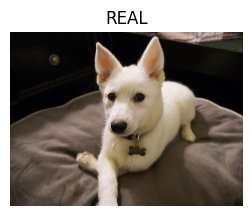


 modelV1:
The inputted image is: REAL | probability of being real: 0.92


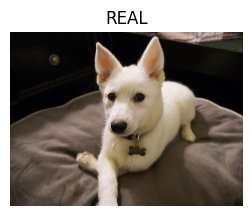


 modelV0:
The inputted image is: REAL | probability of being real: 0.85


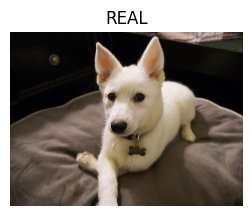

actual label: REAL 



In [ ]:
def test_all_models(url):
  print("modelV2:")
  model_testImagePass(modelV2, url)
  print("\n modelV1:")
  model_testImagePass(modelV1, url)
  print("\n modelV0:")
  model_testImagePass(modelV0, url)

test_all_models(test_image_url)

url = 'https://cdn.pixabay.com/photo/2024/06/03/23/35/ai-generated-8807468_1280.jpg'
test_all_models(url)
# model_testImagePass(modelV2, url)
print("actual label: FAKE \n")

url = 'https://cdn.pixabay.com/photo/2025/08/17/10/46/bird-9779577_1280.png'
test_all_models(url)
# model_testImagePass(modelV2, url)
print("actual label: FAKE \n")

url = 'https://cdn.pixabay.com/photo/2025/08/06/22/31/close-up-portrait-9759768_1280.jpg'
test_all_models(url)
# model_testImagePass(modelV2, url)
print("actual label: FAKE \n")

url = 'https://static.jojowiki.com/images/thumb/8/83/latest/20240516083351/Hirohiko_Araki.png/400px-Hirohiko_Araki.png'
test_all_models(url)
# model_testImagePass(modelV2, url)
print("actual label: REAL \n")

url = 'https://preview.redd.it/the-two-sides-of-her-v0-1ziadmi8a1mf1.jpg?width=1080&crop=smart&auto=webp&s=f13abb486b4ee234f6424ade2c93a197ac8424fb'
test_all_models(url)
# model_testImagePass(modelV2, url)
print("actual label: REAL \n")

url = 'https://i.redd.it/7yfthrgi25d21.jpg'
test_all_models(url)
# model_testImagePass(modelV2, url)
print("actual label: REAL \n")



modelV2:
The inputted image is: REAL | probability of being real: 0.94


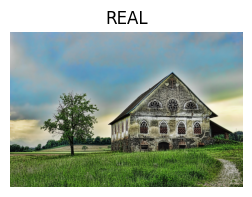


 modelV1:
The inputted image is: REAL | probability of being real: 0.95


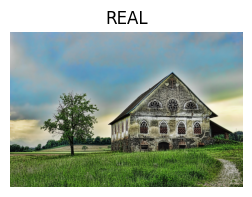


 modelV0:
The inputted image is: REAL | probability of being real: 0.88


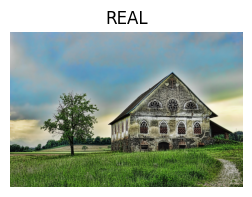

actual label: REAL 

modelV2:
The inputted image is: FAKE | probability of being real: 0.11


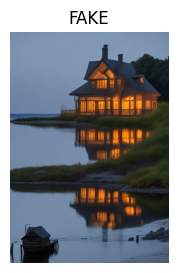


 modelV1:
The inputted image is: FAKE | probability of being real: 0.34


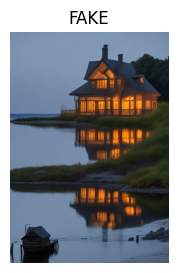


 modelV0:
The inputted image is: FAKE | probability of being real: 0.37


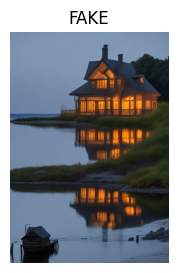

actual label: FAKE 

modelV2:
The inputted image is: REAL | probability of being real: 1.00


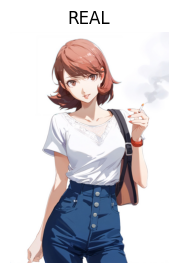


 modelV1:
The inputted image is: REAL | probability of being real: 1.00


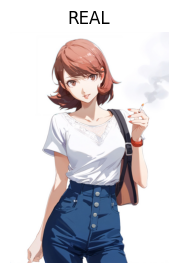


 modelV0:
The inputted image is: REAL | probability of being real: 0.72


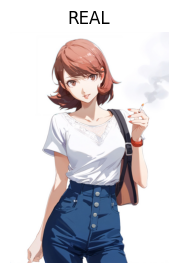

actual label: FAKE 

modelV2:
The inputted image is: REAL | probability of being real: 1.00


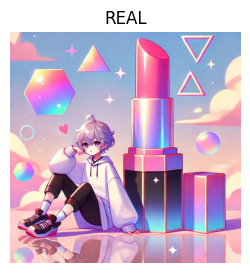


 modelV1:
The inputted image is: REAL | probability of being real: 1.00


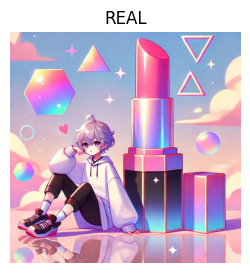


 modelV0:
The inputted image is: REAL | probability of being real: 0.84


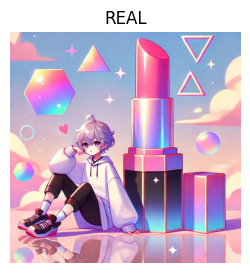

actual label: FAKE 



In [ ]:
url = 'https://cdn.pixabay.com/photo/2018/05/09/23/13/home-3386450_1280.jpg'
test_all_models(url)
print("actual label: REAL \n")

url = 'https://cdn.pixabay.com/photo/2023/05/19/17/38/ai-generated-8005038_1280.jpg'
test_all_models(url)
print("actual label: FAKE \n")

url = 'https://pbs.twimg.com/media/GRwbe73XwAAnpcE?format=jpg&name=large'
test_all_models(url)
print("actual label: FAKE \n")

url = 'https://preview.redd.it/1-prompt-3-tools-3-styles-v0-d1lsmtaxwcnf1.jpg?width=640&crop=smart&auto=webp&s=3ba46bc5bf23e6703016ecdeb924934625cf2ac1'
test_all_models(url)
print("actual label: FAKE \n")

The inputted image is: FAKE | probability of being real: 0.34


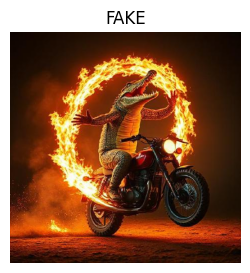

In [ ]:
model_testImagePass(modelV2, 'https://avatars.githubusercontent.com/u/185518562?v=4')

## Export the model

In [ ]:
model_path = Path("models")
model_path.mkdir(parents=True,
                 exist_ok=True)

model_name = "AI_image_detectorV2.pth"
model_save_path = model_path / model_name

print(f"saving modelV2 to {model_save_path}")
torch.save(obj=modelV2.state_dict(),
           f=model_save_path)

saving modelV2 to models/AI_image_detectorV2.pth


The inputted image is: FAKE | probability of being real: 0.34


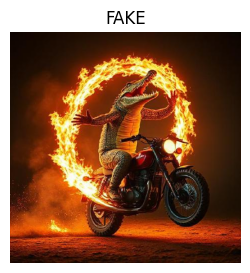

In [ ]:
# verify that the model has saved correctly
setManualSeed()

loaded_modelV2 = AIdentifierV2(
    input_units=3,
    output_units=1,
    hidden_units=16,
    hidden_linear_units=64,
)

loaded_modelV2.load_state_dict(torch.load(f=model_save_path))
loaded_modelV2.to(device)
model_testImagePass(loaded_modelV2, 'https://avatars.githubusercontent.com/u/185518562?v=4')